In [1]:
from mdagent import MDAgent
import os 
import mdtraj as md

In [2]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(parent_dir)
from robustness_prompts import get_prompt

prompt_7_descriptive = get_prompt("descriptive", 7)
prompt_7_natural = get_prompt("natural", 7)

prompt_7_descriptive, prompt_7_natural

('Complete all of the following tasks: 1. Download the PDB file 1LYZ. 2. Report the secondary structure assignments of the downloaded PDB structure. 3. Find any known binding or active sites. 4. Simulate for 1 ps at 300 K. 5. Compute the RMSD. 6. Compute the radius of gyration over time. 7. Compute the SASA (solvent accessible surface area).',
 'Simulate 1LYZ for 1 ps at 300 K. Report the secondary structure assignments of the downloaded PDB structure and any known binding or active sites. Compute the RMSD, SASA, and radius of gyration of the simulation.')

In [3]:
llm_model = "claude-3-5-sonnet-20240620"
tools = "all"

In [4]:
agent_1 = MDAgent(agent_type="Structured", model=llm_model, top_k_tools=tools, use_memory=False)
agent_1.run(prompt_7_descriptive)

Certainly! I'll go through each task step by step using the provided tools.

Thought: Let's start by downloading the PDB file 1LYZ.

Action:
```
{
    "action": "PDBFileDownloader",
    "action_input": "1LYZ"
}
```PDB file found with this ID: 1LYZ
Thought: Great, we've successfully downloaded the PDB file for 1LYZ. Now, let's move on to reporting the secondary structure assignments of this structure.

Action:
```
{
    "action": "ComputeDSSP",
    "action_input": {
        "traj_file": "1LYZ_223947",
        "target_frames": "all"
    }
}
```

Thought: We've obtained the secondary structure assignments for 1LYZ. Now, let's find any known binding or active sites for this protein.

Action:
```
{
    "action": "GetUniprotID",
    "action_input": "1LYZ"
}
```

Thought: We've obtained the UniProt ID for 1LYZ. Now, let's use this ID to find the known binding or active sites for this protein.

Action:
```
{
    "action": "GetAllKnownSites",
    "action_input": {
        "query": "P17897",
   

({'input': '\n    You are an expert molecular dynamics scientist, and\n    your task is to respond to the question or\n    solve the problem to the best of your ability using\n    the provided tools.\n\n    You can only respond with a single complete\n    \'Thought, Action, Action Input\' format\n    OR a single \'Final Answer\' format.\n\n    Complete format:\n    Thought: (reflect on your progress and decide what to do next)\n    Action:\n    ```\n    {\n        "action": (the action name, it should be the name of a tool),\n        "action_input": (the input string for the action)\n    }\n    \'\'\'\n\n    OR\n\n    Final Answer: (the final response to the original input\n    question, once all steps are complete)\n\n    You are required to use the tools provided,\n    using the most specific tool\n    available for each action.\n    Your final answer should contain all information\n    necessary to answer the question and its subquestions.\n    Before you finish, reflect on your pro

<Figure size 640x480 with 0 Axes>

In [5]:
registry_1 = agent_1.path_registry
print(registry_1.list_path_names_and_descriptions().replace(",", "\n"))

Files found in registry: 1LYZ_223947: PDB file downloaded from RSCB
 PDBFile ID: 1LYZ_223947
 rec0_223949: dssp values for trajectory with id: 1LYZ_223947
 1LYZ_224008: Cleaned File:  Removed Heterogens
 and Water Removed.  Replaced Nonstandard Residues. Added Hydrogens at pH 7.0. Missing Atoms Added and replaces nonstandard residues. 
 top_sim0_224012: Initial positions for simulation sim0_224012
 sim0_224012: Basic Simulation of Protein 1LYZ_224008
 rec0_224018: Simulation trajectory for protein 1LYZ_224008 and simulation sim0_224012
 rec1_224018: Simulation state log for protein 1LYZ_224008 and simulation sim0_224012
 rec2_224018: Simulation pdb frames for protein 1LYZ_224008 and simulation sim0_224012
 rmsd_224012: RMSD for 224012
 fig0_224447: RMSD plot for 224012
 rgy_rec0_224018: Radii of gyration per frame for rec0_224018
 fig0_224452: Plot of radii of gyration over time for rec0_224018
 sasa_1LYZ: Total SASA values for 1LYZ
 fig0_231232: Plot of SASA over time for 1LYZ


In [6]:
# make sure pdb was downloaded
assert os.path.exists(registry_1.get_mapped_path("1LYZ_223947"))

In [7]:
# make sure dssp was computed correctly
from mdagent.tools.base_tools import ComputeDSSP

dssp = ComputeDSSP(registry_1)
dssp._run(traj_file= "1LYZ_223947", target_frames="first")

"{'residues in helix': 50, 'residues in strand': 14, 'residues in coil': 65, 'residues not assigned, not a protein residue': 101}"

In [8]:
# make sure the sites were found
from mdagent.tools.base_tools import GetAllKnownSites

get_all_known_sites = GetAllKnownSites()
get_all_known_sites._run(query="1LYZ", primary_accession="P17897")

"Active Sites: [{'start': 53, 'start_modifier': 'EXACT', 'end': 53, 'end_modifier': 'EXACT', 'description': '', 'evidences': [{'evidenceCode': 'ECO:0000255', 'source': 'PROSITE-ProRule', 'id': 'PRU00680'}]}, {'start': 71, 'start_modifier': 'EXACT', 'end': 71, 'end_modifier': 'EXACT', 'description': '', 'evidences': [{'evidenceCode': 'ECO:0000255', 'source': 'PROSITE-ProRule', 'id': 'PRU00680'}]}]\nNo known binding sites.\nNo other relevant sites."

In [9]:
# make sure trajectory and topology exist
traj_path_1 = registry_1.get_mapped_path("rec0_224018")
top_path_1 = registry_1.get_mapped_path("top_sim0_224012")

assert os.path.exists(traj_path_1)
assert os.path.exists(top_path_1)

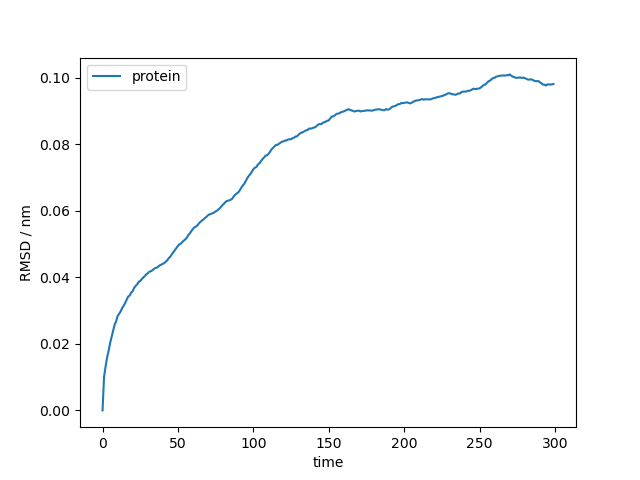

In [10]:
# make sure rmsd plot was generated
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_224447'))

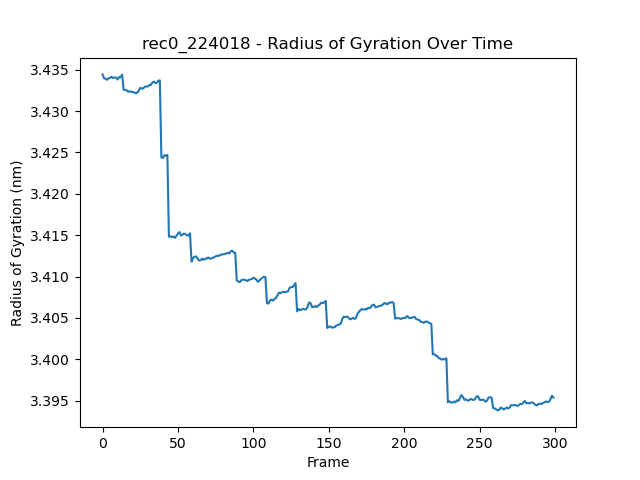

In [11]:
# make sure rgy plot was generated
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_224452'))

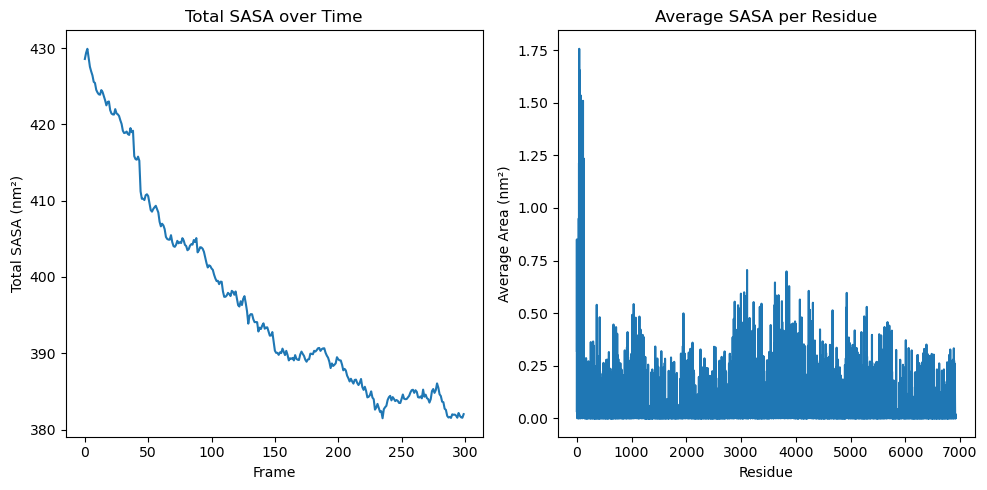

In [12]:
# make sure sasa plot was generated
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_231232'))

In [13]:
agent_2 = MDAgent(agent_type="Structured", model=llm_model, top_k_tools=tools, use_memory=False)
agent_2.run(prompt_7_natural)

Thought: To address this question, we need to follow several steps. First, we'll download the PDB file for 1LYZ, then set up and run a simulation, analyze the secondary structure, find binding and active sites, and finally compute the requested metrics. Let's start by downloading the PDB file.

Action:
```
{
    "action": "PDBFileDownloader",
    "action_input": "1LYZ"
}
```PDB file found with this ID: 1LYZ
Thought: Great, we have successfully downloaded the PDB file for 1LYZ. Now, let's set up and run a short simulation for 1 ps at 300 K.

Action:
```
{
    "action": "SetUpandRunFunction",
    "action_input": {
        "pdb_id": "1LYZ_231752",
        "forcefield_files": ["amber14-all.xml", "amber14/tip3pfb.xml"],
        "system_params": {
            "nonbondedMethod": "PME",
            "nonbondedCutoff": "1 * nanometers",
            "constraints": "HBonds",
            "rigidWater": true,
            "ewaldErrorTolerance": 0.0005,
            "constraintTolerance": 0.000001
     

({'input': '\n    You are an expert molecular dynamics scientist, and\n    your task is to respond to the question or\n    solve the problem to the best of your ability using\n    the provided tools.\n\n    You can only respond with a single complete\n    \'Thought, Action, Action Input\' format\n    OR a single \'Final Answer\' format.\n\n    Complete format:\n    Thought: (reflect on your progress and decide what to do next)\n    Action:\n    ```\n    {\n        "action": (the action name, it should be the name of a tool),\n        "action_input": (the input string for the action)\n    }\n    \'\'\'\n\n    OR\n\n    Final Answer: (the final response to the original input\n    question, once all steps are complete)\n\n    You are required to use the tools provided,\n    using the most specific tool\n    available for each action.\n    Your final answer should contain all information\n    necessary to answer the question and its subquestions.\n    Before you finish, reflect on your pro

<Figure size 640x480 with 0 Axes>

In [14]:
registry_2 = agent_2.path_registry
print(registry_2.list_path_names_and_descriptions().replace(",", "\n"))

Files found in registry: 1LYZ_231752: PDB file downloaded from RSCB
 PDBFile ID: 1LYZ_231752
 1LYZ_231813: Cleaned File:  Removed Heterogens
 and Water Removed.  Replaced Nonstandard Residues. Added Hydrogens at pH 7.0. Missing Atoms Added and replaces nonstandard residues. 
 top_sim0_231818: Initial positions for simulation sim0_231818
 sim0_231818: Basic Simulation of Protein 1LYZ_231813
 rec0_231820: Simulation trajectory for protein 1LYZ_231813 and simulation sim0_231818
 rec1_231820: Simulation state log for protein 1LYZ_231813 and simulation sim0_231818
 rec2_231820: Simulation pdb frames for protein 1LYZ_231813 and simulation sim0_231818
 rec0_232315: dssp values for trajectory with id: rec2_231820
 rmsd_231818: RMSD for 231818
 fig0_232329: RMSD plot for 231818
 sasa_1LYZ: Total SASA values for 1LYZ
 fig0_232726: Plot of SASA over time for 1LYZ
 rgy_rec0_231820: Radii of gyration per frame for rec0_231820
 fig0_232732: Plot of radii of gyration over time for rec0_231820


In [15]:
# make sure pdb was downloaded
assert os.path.exists(registry_2.get_mapped_path("1LYZ_231813"))

In [16]:
# make sure the sites were found
from mdagent.tools.base_tools import GetAllKnownSites

get_all_known_sites = GetAllKnownSites()
get_all_known_sites._run(query="1LYZ", primary_accession="P17897")

"Active Sites: [{'start': 53, 'start_modifier': 'EXACT', 'end': 53, 'end_modifier': 'EXACT', 'description': '', 'evidences': [{'evidenceCode': 'ECO:0000255', 'source': 'PROSITE-ProRule', 'id': 'PRU00680'}]}, {'start': 71, 'start_modifier': 'EXACT', 'end': 71, 'end_modifier': 'EXACT', 'description': '', 'evidences': [{'evidenceCode': 'ECO:0000255', 'source': 'PROSITE-ProRule', 'id': 'PRU00680'}]}]\nNo known binding sites.\nNo other relevant sites."

In [17]:
# make sure trajectory and topology exist
traj_path_2 = registry_2.get_mapped_path("rec0_231820")
top_path_2 = registry_2.get_mapped_path("top_sim0_231818")

assert os.path.exists(traj_path_2)
assert os.path.exists(top_path_2)

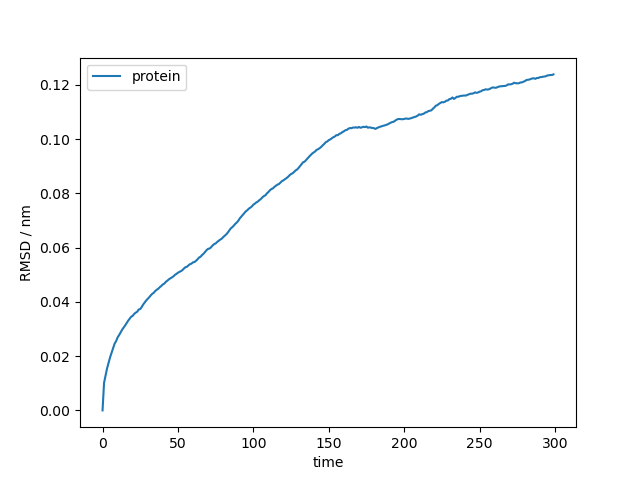

In [18]:
# make sure rmsd plot was generated
from IPython.display import Image
Image(filename=registry_2.get_mapped_path('fig0_232329'))

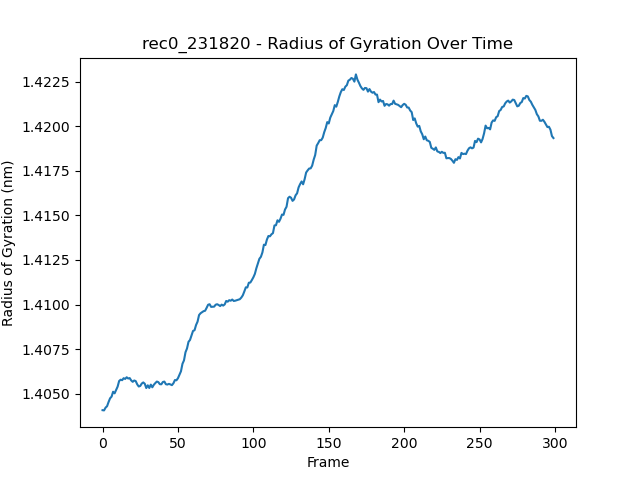

In [19]:
# make sure rgy plot was generated
from IPython.display import Image
Image(filename=registry_2.get_mapped_path('fig0_232732'))

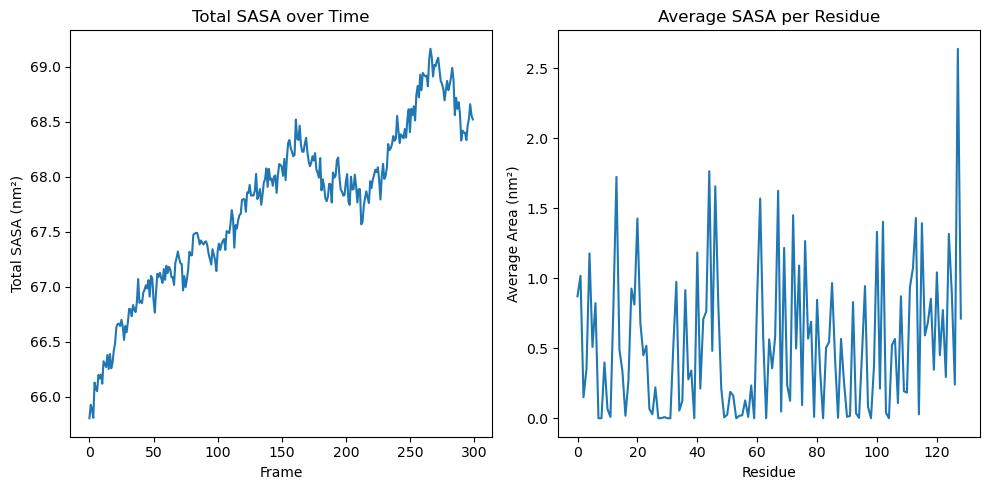

In [20]:
# make sure sasa plot was generated
from IPython.display import Image
Image(filename=registry_2.get_mapped_path('fig0_232726'))